### A quick comparison of "volume" and "interface" solvers

In the GFM famework, there is two main approaches to define the block time integrator. The first one, inspired from Parareal, consists on defining scalar blocks and hide eventual substeps inside. For instance, let be a RK method with stability function $R(z)$, then for $s$ substeps we have as block operators :

$$\phi = R(\lambda\Delta{t}/s)^{-s},\quad \chi=1.$$

For now, we can call it the "interface" approach, which differs from the the second one, that we call "volume" approach, and represents all substeps as nodes for the block of size $s$, which produces the following block operators :

$$\phi = \begin{pmatrix}
R(\lambda\Delta{t}/s)^{-1} & & \\
-1 & R(\lambda\Delta{t}/s)^{-1} & \\
& \ddots & \ddots
\end{pmatrix},\quad 
\chi=
\begin{pmatrix}
0 & \dots & 0 & 1 \\
0 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots
\end{pmatrix}.$$

So those two approaches are equivalent, and it possible to define a $\phi_\Delta$ operator 
(e.g with a lower order method) that will have the same accuracy for both methods.
Now here is the topic of this note :

> For iterative algorithms using only a $\phi_\Delta$ operator (i.e Parareal, Block Jacobi and Block Gauss-Seidel), are those two approaches equivalent ?

In [1]:
# Script import setup
import numpy as np
import matplotlib.pyplot as plt
from gfm.base import GFMSolver
from gfm.util import setFig, getLastPlotCol
plt.rcParams['figure.dpi'] = 100

Let consider $\lambda=1j$, $u_0=1$, $T=5\pi$, and a subdivision into $L=10$ blocks of size $\Delta{t}=0.5\pi$. For the fine solver, we use a Runge-Kutta method of $4^{th}$ order with time step $\delta{t}=0.05\pi$. Now for the "volume" approach, we can build our block solver this way :

In [2]:
sV = GFMSolver(lam=1j, u0=1, dt=0.5*np.pi, L=10)
sV.setFineLevel(
    M=10, method='RK4', qType='RADAU-II', nodes='EQUID')

... and define the $\phi_\Delta$ operator this way :

In [3]:
sV.setPhiDelta(method='FE')

For the "interface" approache, we use the **nStepPerNode** argument (default value at 1) to "hide" the substeps inside the block : 

In [4]:
sI = sV.copy()
sI.setFineLevel(
    M=1, method='RK4', qType='RADAU-II', nodes='EQUID', nStepPerNode=10)

... and define the $\phi_\Delta$ operator similarly :

In [5]:
sI.setPhiDelta(method='FE', nStepPerNode=10)

First we check that the solution obtained with the $\phi$ and the $\phi_\Delta$ operators coincide on the interface :

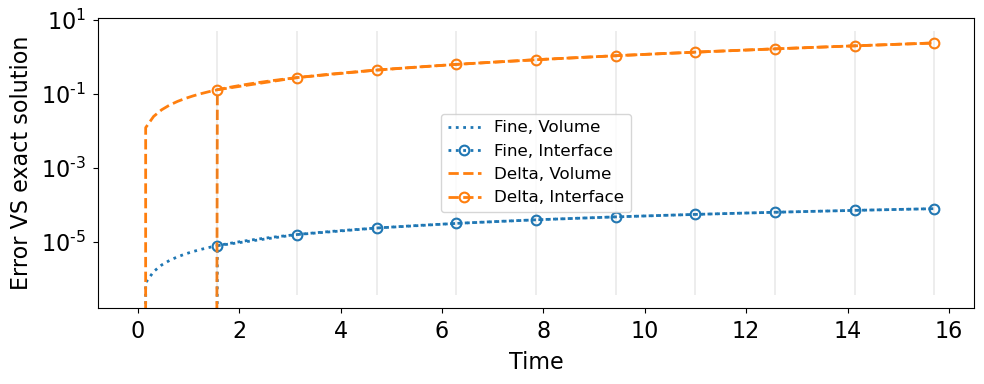

In [6]:
# Retrieve volume solver values
tV, uExactV = sV.getU('Exact', times=True)
uFineV = sV.getU('Fine')
uDeltaV = sV.getU('Delta')
# Retrieve interface solver values
tI, uExactI = sI.getU('Exact', times=True)
uFineI = sI.getU('Fine')
uDeltaI = sI.getU('Delta')
# Plot and compare
plt.semilogy(tV, np.abs(uFineV-uExactV), ':', label='Fine, Volume')
plt.semilogy(tI, np.abs(uFineI-uExactI), 'o:', c=getLastPlotCol(), label='Fine, Interface')
plt.semilogy(tV, np.abs(uDeltaV-uExactV), '--', label='Delta, Volume')
plt.semilogy(tI, np.abs(uDeltaI-uExactI), 'o--', c=getLastPlotCol(), label='Delta, Interface')
plt.vlines(sV.times[:, -1], *plt.ylim(), colors='gray', linewidth=0.2)
setFig('Time', 'Error VS exact solution', figSize=(10, 4))
yLim = plt.ylim()  # storing y-limits for next figure ...

As expected, each solution are identical on the interface. 
Now let's run Parareal, Block Gauss-Seidel and Block Jacobi with both solvers, and plot the error versus the fine solution for each block after 5 iterations, using $\mathbf{u}^k=0$ as initialization for each algorithms :

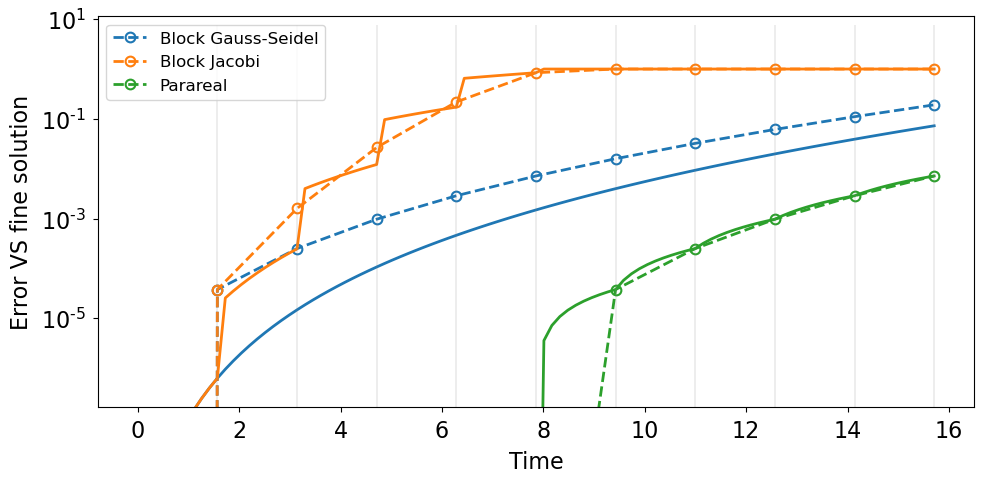

In [7]:
nIter = 5
iType = 'ZERO'

lStyles = ['o--', '-']
tVec = [tI, tV]
uRef = [uFineI, uFineV]

algos = ['GaussSeidel', 'Jacobi', 'Parareal']
colors = [None, None, None]
labels = ['Block Gauss-Seidel', 'Block Jacobi', 'Parareal']

# Loop for interface and volume
for i, s in enumerate([sI, sV]):
    # Loop for each algorithms
    for j, algo in enumerate(algos):
        # Compute solution
        uAlgo = s.getInitU(iType)
        for k in range(nIter):
            s.iterate(algo, uAlgo)
        uAlgo = s.getU(uAlgo)
        # Plot
        plt.semilogy(tVec[i], np.abs(uAlgo-uRef[i]), lStyles[i],
                     c=colors[j], label=labels[j])
        colors[j] = getLastPlotCol()
        labels[j] = None
# Plot settings
plt.vlines(sV.times[:, -1], *plt.ylim(), colors='gray', linewidth=0.2)
plt.ylim(*yLim)
setFig('Time', 'Error VS fine solution', figSize=(10, 5))

Here the "volume" approach is represented with continuous lines, while the "interface" approach is plotted with dashes. Here is some first observations we can make :

* for Parareal, the chosen approach does not have an impact on the computed interface values, thus we can say that this is the same algorithm considering both approaches. 
* for Block Jacobi and Block Gauss-Seidel, this isn't true anymore : chosing the "interface" or "volume" approach gives two similar but different algorithms.
* the "volume" approach provides a better convergence for Block Gauss-Seidel, while it is somewhat equivalent for Block Jacobi in most block.